In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.2 MB/s eta 0:00:00
Mounted at /content/gdrive


# Image Classifier Example

In [2]:
from fastai.vision.all import *

# Fetch the data
cat_path = untar_data(URLs.PETS)/'images'

# Define classification function
def is_cat(x): return x[0].isupper()

# Create a data loader
cat_dls = ImageDataLoaders.from_name_func(
    cat_path,
    get_image_files(cat_path),
    valid_pct=0.2,
    seed=42,
    label_func=is_cat,
    item_tfms=Resize(224)
)

# Define a learner using our data and a pre-trained model
cat_learn = vision_learner(cat_dls, resnet34, metrics=error_rate)

# Fine tune the model
cat_learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 113MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.166484,0.026324,0.010825,00:46


epoch,train_loss,valid_loss,error_rate,time
0,0.040441,0.027487,0.006766,00:46
1,0.022456,0.033723,0.008796,00:47
2,0.043597,0.111792,0.017591,00:46
3,0.032204,0.011016,0.003383,00:46
4,0.018457,0.009195,0.004060,00:47
5,0.011434,0.006689,0.002030,00:51
6,0.007427,0.003759,0.001353,00:49
7,0.003025,0.003408,0.002030,00:45
8,0.001312,0.004001,0.001353,00:46
9,0.001077,0.002926,0.001353,00:47


In [3]:
# Upload sample image for testing
cat_uploader = widgets.FileUpload()
cat_uploader

FileUpload(value={}, description='Upload')

In [6]:
# Run model with sample image
cat_img = PILImage.create(cat_uploader.data[0])
is_cat,_,probs = cat_learn.predict(cat_img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: True.
Probability it's a cat: 1.000000


# Segmentation Example

In [7]:
# Fetch the data
segmentation_path = untar_data(URLs.CAMVID_TINY)

# Create data loader
segmentation_dls = SegmentationDataLoaders.from_label_func(
    segmentation_path,
    bs=8,
    fnames = get_image_files(segmentation_path/"images"),
    label_func = lambda o: segmentation_path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(segmentation_path/'codes.txt', dtype=str)
)

# Define a learner using the data and a pre-trained model
segmentation_learn = unet_learner(segmentation_dls, resnet34)

# Fine-tune the model
segmentation_learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,2.875216,2.350110,00:01


epoch,train_loss,valid_loss,time
0,1.951921,1.685251,00:01
1,1.669196,1.341931,00:01
2,1.481618,1.133638,00:01
3,1.324814,0.913476,00:01
4,1.178772,0.797314,00:01
5,1.060294,0.766890,00:01
6,0.962307,0.729690,00:01
7,0.886543,0.725828,00:01


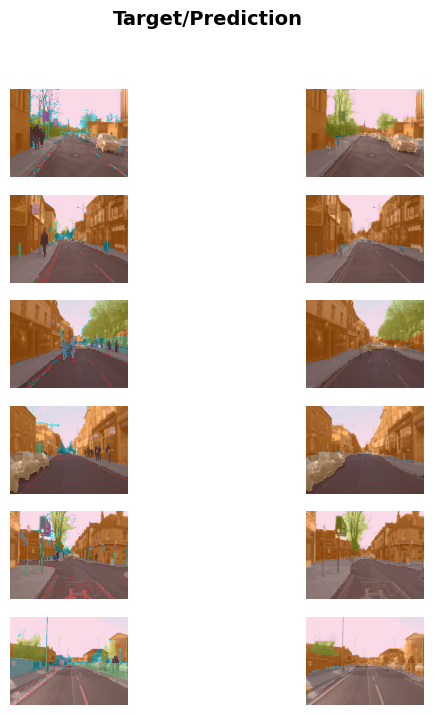

In [8]:
#View the results
segmentation_learn.show_results(max_n=6, figsize=(7,8))

# Sentiment Example

In [9]:
from fastai.text.all import *

# Fetch the data
movie_dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test', bs=32)

# Define the learner using the data and a pre-trained model,
movie_learn = text_classifier_learner(movie_dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

# Fine tune the model
# - use 4 epochs after the initial head-only training epoch
# - use 0.01 as learning rate
movie_learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.477150,0.399705,0.820960,04:33


epoch,train_loss,valid_loss,accuracy,time
0,0.317354,0.250952,0.900920,08:37
1,0.245205,0.229302,0.907000,08:37
2,0.194622,0.183930,0.928400,08:37
3,0.152518,0.184150,0.931600,08:37


In [12]:
movie_learn.predict("I really hated that movie!")

('neg', tensor(0), tensor([0.8286, 0.1714]))

# Fast AI Helpers

In [17]:
! [ -e /content ] && pip install -Uqq nbdev
# Get function documentation
doc(movie_learn.predict)

# Tabular Data Examples

In [19]:
# Income Prediction Example
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~
from fastai.tabular.all import *

# Fetch the data
income_path = untar_data(URLs.ADULT_SAMPLE)

# Create a data loader
income_dls = TabularDataLoaders.from_csv(
    income_path/'adult.csv',
    path=income_path,
    y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

# Define a learner using the data.
income_learn = tabular_learner(income_dls, metrics=accuracy)

# Train the model from scratch - no transfer learning here.
# (There are few pre-trained models for tabular data)
income_learn.fit_one_cycle(3)

/usr/local/lib/python3.11/dist-packages/fastai/tabular/core.py:314: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to[n].fillna(self.na_dict[n], inplace=True)


epoch,train_loss,valid_loss,accuracy,time
0,0.384291,0.372548,0.824785,00:04
1,0.355486,0.358876,0.830620,00:04
2,0.346642,0.353408,0.836149,00:04


In [22]:
# Recomendation System Example
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~
from fastai.collab import *

# Fetch the data
path = untar_data(URLs.ML_SAMPLE)

# Create a data loader
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

# Define a learner using the data
learn = collab_learner(dls, y_range=(0.5,5.5))

# Train the model.
# (Trains from scratch, no transfer learning here.)
learn.fine_tune(10)

# View results
learn.show_results()

epoch,train_loss,valid_loss,time
0,1.483972,1.478474,00:00


epoch,train_loss,valid_loss,time
0,1.398551,1.425059,00:00
1,1.275656,1.272771,00:00
2,1.051663,0.977252,00:00
3,0.834134,0.773205,00:00
4,0.708823,0.714003,00:00
5,0.649804,0.694689,00:00
6,0.632409,0.686570,00:00
7,0.612561,0.684391,00:00
8,0.590378,0.682586,00:00
9,0.575222,0.682332,00:00


,userId,movieId,rating,rating_pred
0,20.0,47.0,3.5,3.936857
1,41.0,44.0,4.0,3.336724
2,38.0,25.0,4.5,3.644142
3,5.0,52.0,4.0,4.318454
4,72.0,77.0,3.0,3.500011
5,74.0,65.0,4.0,3.900765
6,7.0,64.0,2.0,3.730943
7,22.0,52.0,4.0,3.572095
8,9.0,26.0,2.5,3.535403
